data citation:
Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.



# **X Ray Deep Learning ____________________________**

##### Author: Spencer Hadel
***
### Overview

NAOJGAKJGK:LMA:LJHLJ:Ll;

Include stats by profesioanl observations on kaggle etc

include goal numbers to beat etc.


***



***
## Perparation and EDA


In [1]:
#basic imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import glob

#keras for images
import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import preprocessing

the data from kaggle is separated into 3 folders (train, test, and validation). each of these folders contains two folders, labeled normal and pneumonia. we now get the data from each of these folders and subfolders and separate them into three different datasets with two different classes (normal and pneumonia).

In [2]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


# explain why train, test, and val exist!

In [3]:
#directories for loading data

train_dir = 'data/kaggle--chest_xray/train'
test_dir = 'data/kaggle--chest_xray/test'
val_dir = 'data/kaggle--chest_xray/val'

First we will use Keras to create image data generators for all of our data:

In [4]:
train_generator = ImageDataGenerator(
    rescale=1./255
)

In [5]:
# All images will be rescaled by 1./255

#explain size

#explain class_mode

#explain what this code does

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        #binary classification problem:
        class_mode='binary')


#set shuffle to false for val and test data!

val_data = val_datagen.flow_from_directory(
        val_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        shuffle= False,
        #binary classification problem:
        class_mode='binary')

test_data = test_datagen.flow_from_directory(
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        shuffle = False,
        #binary classification problem:
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We successfully created datsets for train, test, and val!

Next let's check what the "2 classes" in this data are:

In [6]:
#identify class labels in data
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

We can see that 'NORMAL' is class 0 and 'PNEUMONIA' is class 1. 

If we were to count the image files in the data folders, we could see that there are 1341 images in the training dataset in the NORMAL subfolder, and 3875 images in the PNEUMONIA subfolder. Our next step is to quickly verify that our data in the notebook matches these results, as well as those in the test and val folders:

In [7]:
from collections import Counter

train_counter = Counter(train_data.classes)    
test_counter = Counter(test_data.classes)    
val_counter = Counter(val_data.classes)    

#train:
print('Train:')
print('NORMAL: ', train_counter[0])
print('PNEUMONIA: ', train_counter[1])
print('')

#test:
print('Test:')
print('NORMAL: ', test_counter[0])
print('PNEUMONIA: ', test_counter[1])
print('')

#val:
print('Validation:')
print('NORMAL: ', val_counter[0])
print('PNEUMONIA: ', val_counter[1])
print('')

Train:
NORMAL:  1341
PNEUMONIA:  3875

Test:
NORMAL:  234
PNEUMONIA:  390

Validation:
NORMAL:  8
PNEUMONIA:  8



These numbers do in fact line up! Let's also get a better understanding of how that data is balanced:

In [8]:
#print percentage of NORMAL results in each set
train_norm_percent = train_counter[0]/(train_counter[0]+train_counter[1])
test_norm_percent = test_counter[0]/(test_counter[0]+test_counter[1])
val_norm_percent = val_counter[0]/(val_counter[0]+val_counter[1])

print('Percent NORMAL in train: {0:.0%}'.format(train_norm_percent))
print('Percent NORMAL in test: {0:.0%}'.format(test_norm_percent))
print('Percent NORMAL in val: {0:.0%}'.format(val_norm_percent))

Percent NORMAL in train: 26%
Percent NORMAL in test: 38%
Percent NORMAL in val: 50%


So the data is most imbalanced in the train, less so in test, and not at all imbalanced in val. That being said, the data is never drastically imbalanced, and there are still plenty of each of the two classes in the train dataset to create successful models with.

### Observing the Images

Our next step is to analyze what this image data actually contains!

We'll use the images in the validation folder for examples of NORMAL and PNEUMONIA classes.

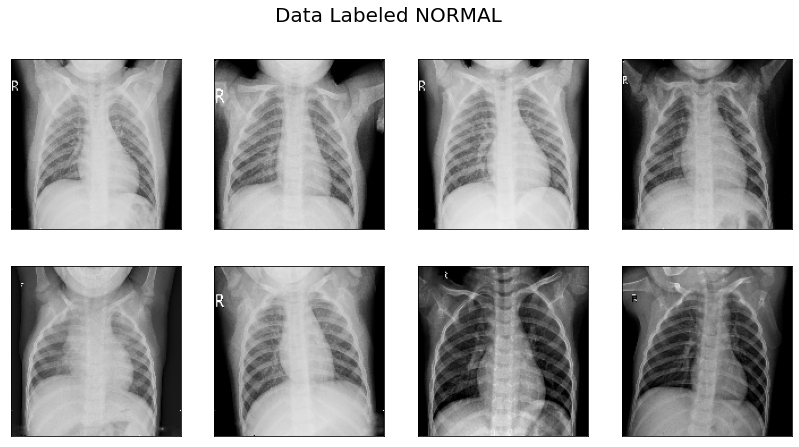

In [9]:
#collect only images where label is 0 (NORMAL)
norm_imgs = val_data[0][0][val_data[0][1]==0]
normal_fig,normal_ax = plt.subplots(2,4,figsize=(14,7))

for idx,image in enumerate(norm_imgs[:8]):
        active_axis = normal_ax[idx//4][idx%4]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Data Labeled NORMAL', fontsize=20);

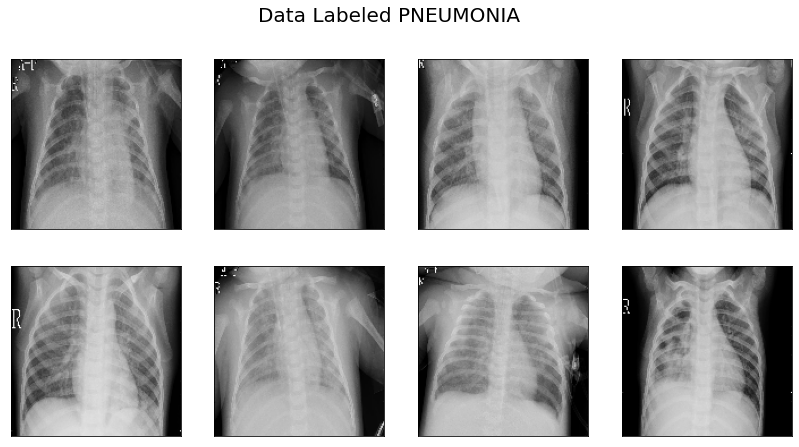

In [10]:
#collect only images where label is 1 (PNEUMONIA)
norm_imgs = val_data[0][0][val_data[0][1]==1]
normal_fig,normal_ax = plt.subplots(2,4,figsize=(14,7))

for idx,image in enumerate(norm_imgs[:8]):
        active_axis = normal_ax[idx//4][idx%4]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Data Labeled PNEUMONIA', fontsize=20);

# As you can see, _________________________________________________________________

In [11]:
# talk about images

## Modeling the Data

In [12]:
#import models

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#### Metrics

#SCORING:
#- NOT accuracy at end, but WILL view it in model fitting stage

#- we like recall/sensitivity! the cost of a false negative can mean undiagnosed illness!

#- therefore we will show recall in epochs but mainly worry about recall on test data
 
 ##rqqf
 ##ggga
 
 
#- explain positive and negative in this case, what we want, what we dont want

#LOSS METRICS AS WELL:

#mse, log loss, binary crossentropy, etc!

#explain dataframe for storing scores as well

In [13]:
my_metrics = [metrics.BinaryAccuracy(),
              metrics.Precision(),
                metrics.Recall()]

In [14]:
#create dataframe for storing scores

df_model_scores = pd.DataFrame(columns = ['Model Name', 'Accuracy', 'Loss', 'Precision', 'Recall'])
#print(df_model_scores)

### Baseline Convolutional Model

binary crossentropy -- good for binary classification -- EXPLAIN

WHY SIGMOID GOOD TO END WITH? - ' if this is binary classification you need to use sigmoid activation at the output'

explain stochastic gradient descent good for binary too


#### Designing the Model

#explain dense
#explain flatten

##### ___________________________________________________________________________

#explain conv2d

#explain pooling

##### ___________________________________________________________________________

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#FLATTEN to fix input shape
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

#sigmoid output
model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    #stochastic gradient descent optimizer:
    optimizer='sgd',
    
    #binar crossentropy loss:
    loss='binary_crossentropy',
    
    #metrics
    metrics=[my_metrics]
    )

#summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

##### ___________________________________________________________________________

#### Training

explain epoch, batch size, etc

epoch 20 as baseline (for shit cpu)

try gpu with higher epochs

In [16]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data to prevent overfitting to training data
    validation_data=val_data,
    batch_size = 32
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 149s 909ms/step - loss: 0.5145 - binary_accuracy: 0.7634 - precision: 0.7700 - recall: 0.9719 - val_loss: 1.4641 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 179s 1s/step - loss: 0.3576 - binary_accuracy: 0.8554 - precision: 0.8722 - recall: 0.9437 - val_loss: 1.0241 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 180s 1s/step - loss: 0.2378 - binary_accuracy: 0.9053 - precision: 0.9253 - recall: 0.9492 - val_loss: 1.2789 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 164s 1s/step - loss: 0.1899 - binary_accuracy: 0.9262 - precision: 0.9413 - recall: 0.9605 - val_loss: 0.4798 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/30
163/163 [=====================

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

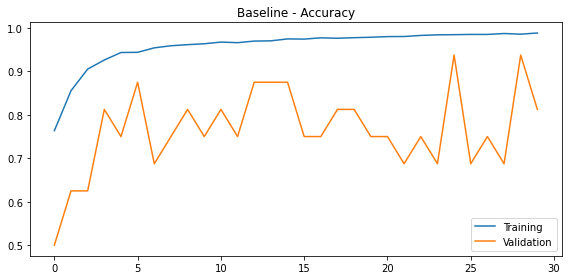

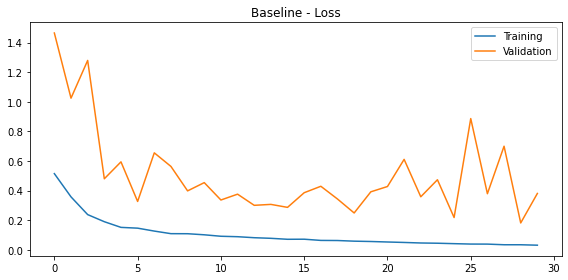

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True

fig1 = plt.figure()
plt.title('Baseline - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()


fig2 = plt.figure()
plt.title('Baseline - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check the model's ability to make predictions on the test dataset. We will display these predictions in the form of a confusion matrix showing the predictions and true labels for each item in the data.

In [18]:
# create confusion matrix helper function:
def plot_confusion(title, save_name):
    #round to get binary assignment from prediction
    preds = np.round(model.predict(test_data),0)
    test_labels = test_data.labels

    #confusion matrix for test data
    conf_matrix = confusion_matrix(test_labels,preds)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    plt.savefig('./img/'+save_name+'.png')
    plt.show()

20/20 [==============================] - 12s 569ms/step


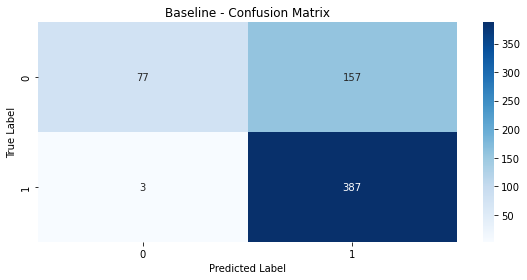

In [19]:
plot_confusion('Baseline - Confusion Matrix', '1-baseline-conf')

The above confusion matrix shows the 4 different types of predictions a model can make. As a refresher:

__True Positives (Bottom Right)__ indicate the that model accurately predicting Pneumonia in an X-Ray.

__True Negatives (Top Left)__ indicate that the model accurately predicted that the X-Ray was of a healthy subject.

__False Positives (Top Right)__ indicate that the model innacurately assessed the X-Ray as indicating Pneumonia, when in fact the patient was healthy.

__False Negatives (Bottom Left)__ similarly show a prediction that the X-Ray was that of a healthy patient, when the correct assessment would be Pneumonia.

The most important number we want to focus on is the one in the __False Negatives__ box. Ideally, this number will be as close to 0 as possible in order to avoid ever misdiagnosing a patient as healthy, thus putting them at significant risk!

This model shows 

##### _______________________________________________

In [20]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 12s 551ms/step - loss: 1.5266 - binary_accuracy: 0.7436 - precision: 0.7114 - recall: 0.9923


In [21]:
model_name = 'Baseline CNN'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.74359,1.52663,0.711397,0.992308


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [22]:
#save info for later retrieval:

#model and history
model.save('./models/1-baseline')
model_1 = model
history_1 = history

#acc and loss charts
fig1.savefig('./img/1-base-acc.png')
fig2.savefig('./img/1-base-loss.png')

INFO:tensorflow:Assets written to: ./models/1-baseline\assets


INFO:tensorflow:Assets written to: ./models/1-baseline\assets


### Model 2 - Increase Batch Size

##### ___________________________________________________________________________

#### Designing the Model

##### ___________________________________________________________________________

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

##### ___________________________________________________________________________

#### Training

In [24]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data to prevent overfitting to training data
    validation_data=val_data,
    batch_size = 64
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 158s 961ms/step - loss: 0.5244 - binary_accuracy: 0.7553 - precision: 0.7561 - recall: 0.9815 - val_loss: 1.1565 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 152s 932ms/step - loss: 0.3760 - binary_accuracy: 0.8413 - precision: 0.8609 - recall: 0.9378 - val_loss: 0.6974 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 151s 926ms/step - loss: 0.2467 - binary_accuracy: 0.9024 - precision: 0.9199 - recall: 0.9515 - val_loss: 0.4617 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 155s 949ms/step - loss: 0.1982 - binary_accuracy: 0.9224 - precision: 0.9401 - recall: 0.9564 - val_loss: 0.7635 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

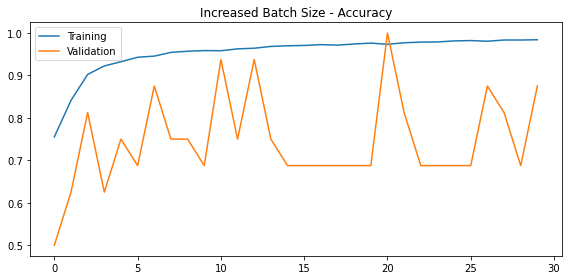

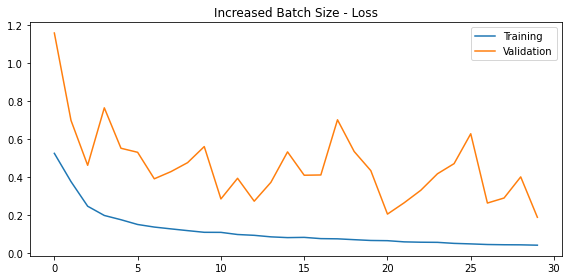

In [25]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Increased Batch Size - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()


fig2 = plt.figure()
plt.title('Increased Batch Size - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 8s 387ms/step


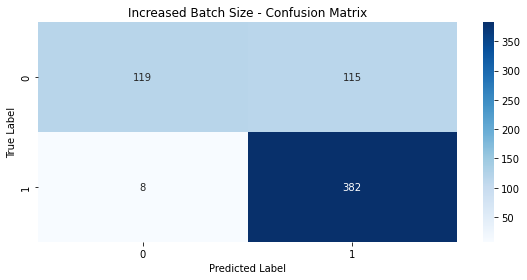

In [26]:
plot_confusion('Increased Batch Size - Confusion Matrix', '2-batch-conf')

This confision matrix shows us that

##### _______________________________________________

In [27]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 8s 376ms/step - loss: 0.7794 - binary_accuracy: 0.8029 - precision: 0.7686 - recall: 0.9795


In [28]:
model_name = 'Increased Batch Size'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [29]:
#save info for later retrieval:

#model and history
model.save('./models/2-increased-batch')
model_2 = model
history_2 = history

#acc and loss charts
fig1.savefig('./img/2-batch-acc.png')
fig2.savefig('./img/2-batch-loss.png')

INFO:tensorflow:Assets written to: ./models/2-increased-batch\assets


INFO:tensorflow:Assets written to: ./models/2-increased-batch\assets


### Model 3 - Augment Training Data


##### ___________________________________________________________________________

In [30]:
#augment data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

aug_train_data = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150,150),
                                                    class_mode='binary') 

Found 5216 images belonging to 2 classes.


As an example, lets look at how any particular image might be augmented by this new datagen:

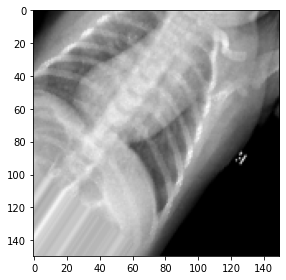

In [31]:
plt.imshow(aug_train_data[0][0][0])

We can see that in this random example, the X Ray image is noticeably askew. This will help our model learn

##### ___________________________________________________________________

Next, we will reduce the imbalance 

#### Designing the Model

##### ___________________________________________________________________________

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
# model.summary()

##### ___________________________________________________________________________
(same model as before)

#### Training

In [33]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 108s 661ms/step - loss: 0.5076 - binary_accuracy: 0.7603 - precision: 0.7673 - recall: 0.9641 - val_loss: 1.0688 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 108s 662ms/step - loss: 0.3459 - binary_accuracy: 0.8585 - precision: 0.8795 - recall: 0.9381 - val_loss: 0.7090 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 107s 654ms/step - loss: 0.2363 - binary_accuracy: 0.9061 - precision: 0.9256 - recall: 0.9499 - val_loss: 0.9510 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 106s 650ms/step - loss: 0.1855 - binary_accuracy: 0.9287 - precision: 0.9451 - recall: 0.9597 - val_loss: 0.4061 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

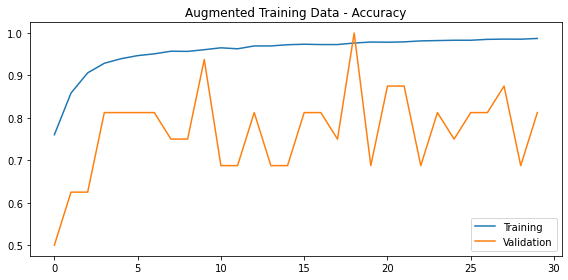

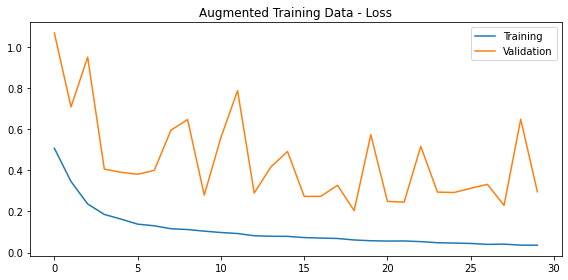

In [34]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True



fig1 = plt.figure()
plt.title('Augmented Training Data - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()



fig2 = plt.figure()
plt.title('Augmented Training Data - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 9s 426ms/step


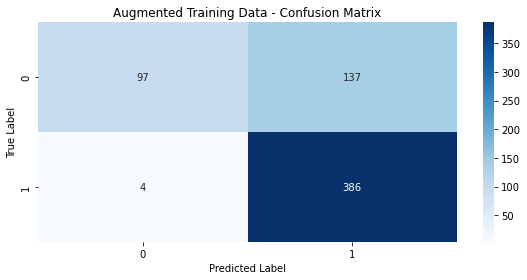

In [35]:
plot_confusion('Augmented Training Data - Confusion Matrix', '3-aug-data-conf')

This confision matrix shows us that

##### _______________________________________________

In [36]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 9s 402ms/step - loss: 1.1999 - binary_accuracy: 0.7740 - precision: 0.7380 - recall: 0.9897


In [37]:
model_name = 'Augmented Training Data'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [38]:
#save info for later retrieval:

#model and history
model.save('./models/3-augmented-data')
model_3 = model
history_3 = history

#acc and loss charts
fig1.savefig('./img/3-augmented-data-acc.png')
fig2.savefig('./img/3-augmented-data-loss.png')

INFO:tensorflow:Assets written to: ./models/3-augmented-data\assets


INFO:tensorflow:Assets written to: ./models/3-augmented-data\assets


### Model 4 - More Layers

##### ___________________________________________________________________________

NOTE THAT THIS WILL USE AUGMENTED

#### Designing the Model

In [39]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

##### ___________________________________________________________________________

#### Training

In [40]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 138s 843ms/step - loss: 0.5856 - binary_accuracy: 0.7443 - precision: 0.7426 - recall: 0.9948 - val_loss: 0.8756 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 132s 808ms/step - loss: 0.5701 - binary_accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.7758 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 129s 789ms/step - loss: 0.5637 - binary_accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.8329 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 128s 782ms/step - loss: 0.5508 - binary_accuracy: 0.7448 - precision: 0.7455 - recall: 0.9969 - val_loss: 0.6893 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

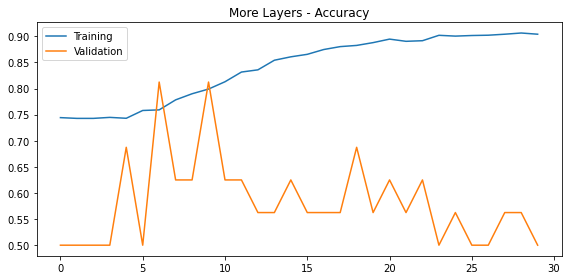

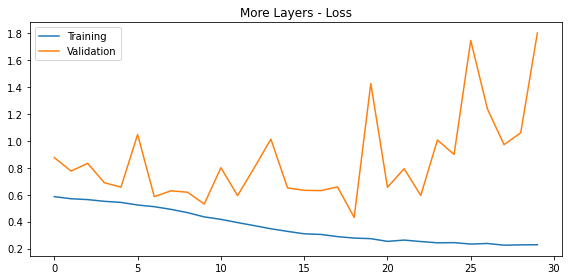

In [41]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('More Layers - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('More Layers - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 9s 415ms/step


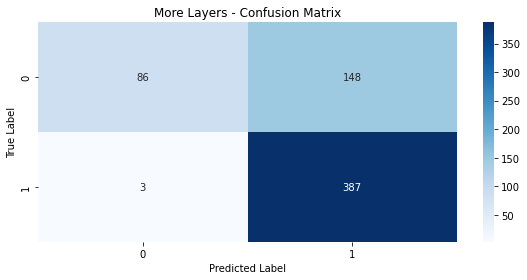

In [42]:
plot_confusion('More Layers - Confusion Matrix', '4-more-layers-conf')

This confision matrix shows us that

##### _______________________________________________

In [43]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 9s 417ms/step - loss: 0.6487 - binary_accuracy: 0.7580 - precision: 0.7234 - recall: 0.9923


In [44]:
model_name = 'More Layers'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744
3,More Layers,0.758013,0.648688,0.723364,0.992308


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [45]:
#save info for later retrieval:

#model and history
model.save('./models/4-more-layers')
model_4 = model
history_4 = history

#acc and loss charts
fig1.savefig('./img/4-more-layers.png')
fig2.savefig('./img/4-more-layers.png')

INFO:tensorflow:Assets written to: ./models/4-more-layers\assets


INFO:tensorflow:Assets written to: ./models/4-more-layers\assets


### Model 5 - New Optimizer - RMSprop

RMSprop(lr=2e-5)

##### ___________________________________________________________________________

#### Designing the Model

##### ___________________________________________________________________________

In [46]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
# model.summary()

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [47]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 142s 858ms/step - loss: 0.5805 - binary_accuracy: 0.7442 - precision: 0.7411 - recall: 0.9986 - val_loss: 0.7631 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 139s 854ms/step - loss: 0.5494 - binary_accuracy: 0.7431 - precision: 0.7433 - recall: 0.9992 - val_loss: 0.8891 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 137s 838ms/step - loss: 0.4910 - binary_accuracy: 0.7682 - precision: 0.7697 - recall: 0.9817 - val_loss: 0.9335 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 128s 782ms/step - loss: 0.4385 - binary_accuracy: 0.7995 - precision: 0.8157 - recall: 0.9432 - val_loss: 0.5914 - val_binary_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.7500
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

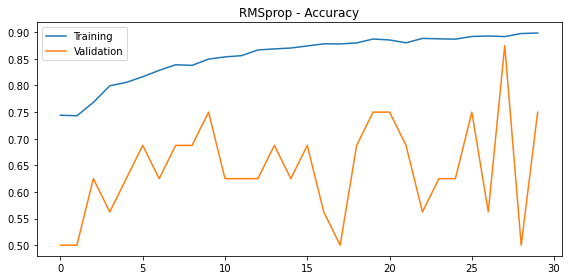

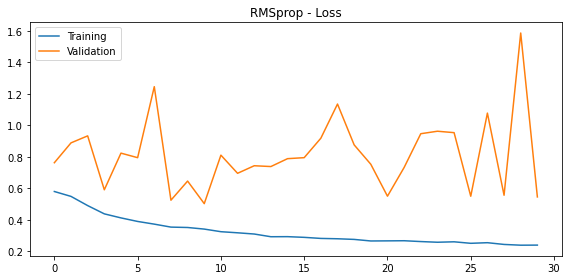

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('RMSprop - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('RMSprop - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 9s 405ms/step


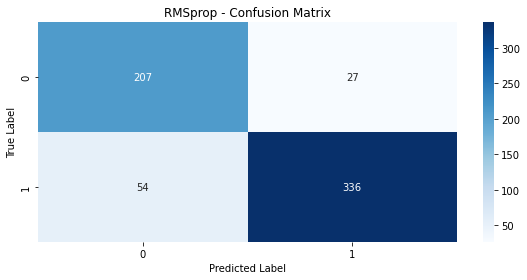

In [49]:
plot_confusion('RMSprop - Confusion Matrix', '5-rmsprop-conf')

This confision matrix shows us that

##### _______________________________________________

In [50]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 8s 387ms/step - loss: 0.3021 - binary_accuracy: 0.8702 - precision: 0.9256 - recall: 0.8615


In [51]:
model_name = 'RMSprop Optimizer'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744
3,More Layers,0.758013,0.648688,0.723364,0.992308
4,RMSprop Optimizer,0.870192,0.302059,0.925620,0.861538


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [52]:
#save info for later retrieval:

#model and history
model.save('./models/5-even-more-layers')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/5-rmsprop-acc.png')
fig2.savefig('./img/5-rmsprop-loss.png')

INFO:tensorflow:Assets written to: ./models/5-even-more-layers\assets


INFO:tensorflow:Assets written to: ./models/5-even-more-layers\assets


### Model 6 - New Optimizer - Adam

##### ___________________________________________________________________________

#### Designing the Model

##### ___________________________________________________________________________

In [53]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
# model.summary()

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [54]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
    
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 137s 832ms/step - loss: 0.5196 - binary_accuracy: 0.7510 - precision: 0.7655 - recall: 0.9501 - val_loss: 0.6777 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 142s 871ms/step - loss: 0.4538 - binary_accuracy: 0.7579 - precision: 0.7918 - recall: 0.9146 - val_loss: 0.5131 - val_binary_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 146s 895ms/step - loss: 0.4180 - binary_accuracy: 0.7960 - precision: 0.8263 - recall: 0.9185 - val_loss: 0.6155 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 147s 903ms/step - loss: 0.3811 - binary_accuracy: 0.8257 - precision: 0.8624 - recall: 0.9107 - val_loss: 0.4294 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

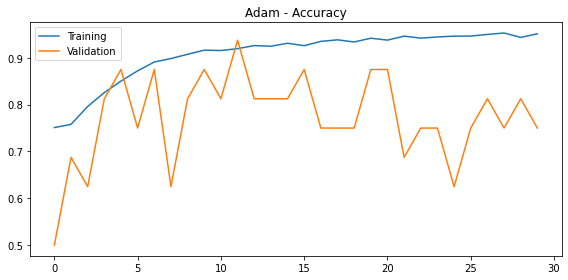

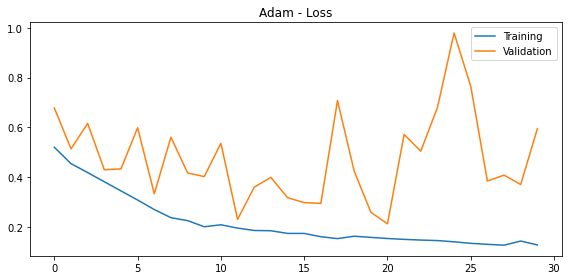

In [55]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Adam - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('Adam - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 10s 439ms/step


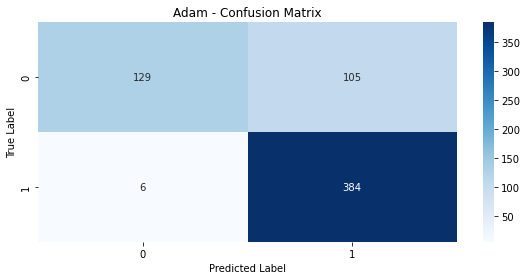

In [56]:
plot_confusion('Adam - Confusion Matrix', '6-adam-conf')

This confision matrix shows us that

##### _______________________________________________

In [57]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 9s 423ms/step - loss: 0.4376 - binary_accuracy: 0.8221 - precision: 0.7853 - recall: 0.9846


In [58]:
model_name = 'Adam Optimizer'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744
3,More Layers,0.758013,0.648688,0.723364,0.992308
4,RMSprop Optimizer,0.870192,0.302059,0.925620,0.861538
5,Adam Optimizer,0.822115,0.437568,0.785276,0.984615


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [59]:
#save info for later retrieval:

#model and history
model.save('./models/6-adam')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/6-adam-acc.png')
fig2.savefig('./img/6-adam-loss.png')

INFO:tensorflow:Assets written to: ./models/6-adam\assets


INFO:tensorflow:Assets written to: ./models/6-adam\assets


### Model 7 - Implement Regularization

Using Dropout to 

"
Dropout Regularization is a technique for reducing overfitting and improve generalization (the ability for the model to make valuable predictions on a new set of data). Specifically, the dropout technique allows the model to emulate a very large model because it randomly discards nodes. The model will still have the number of layers originally created, but the nodes will randomly be thrown out. This method is useful for reducing compute intensity and incorporates an element of randomness that's effective for reducing overfitting.
"

#### Designing the Model

##### ___________________________________________________________________________

In [60]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#DROPOUT REGULARIZATION:
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 128)     

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [61]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
    
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 146s 890ms/step - loss: 0.5538 - binary_accuracy: 0.7485 - precision: 0.7579 - recall: 0.9632 - val_loss: 0.6163 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8750
Epoch 2/30
163/163 [==============================] - 144s 883ms/step - loss: 0.4669 - binary_accuracy: 0.7590 - precision: 0.7930 - recall: 0.9143 - val_loss: 0.6854 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 138s 843ms/step - loss: 0.4388 - binary_accuracy: 0.7776 - precision: 0.8126 - recall: 0.9107 - val_loss: 0.5221 - val_binary_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 4/30
163/163 [==============================] - 133s 816ms/step - loss: 0.4089 - binary_accuracy: 0.7952 - precision: 0.8360 - recall: 0.9012 - val_loss: 0.7309 - val_binary_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

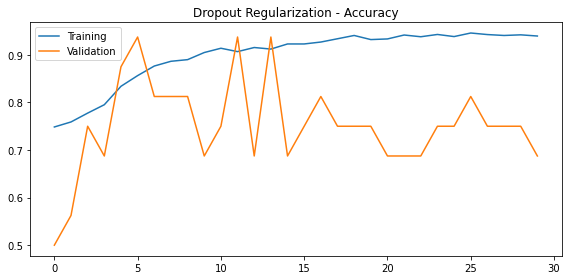

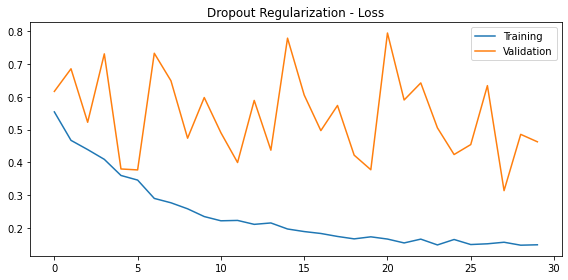

In [62]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Dropout Regularization - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('Dropout Regularization - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 8s 383ms/step


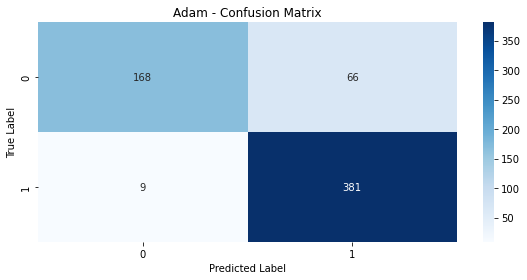

In [63]:
plot_confusion('Adam - Confusion Matrix', '7-dropout-conf')

This confision matrix shows us that

##### _______________________________________________

In [64]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 9s 398ms/step - loss: 0.3194 - binary_accuracy: 0.8798 - precision: 0.8523 - recall: 0.9769


In [65]:
model_name = 'Dropout Regularization'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744
3,More Layers,0.758013,0.648688,0.723364,0.992308
4,RMSprop Optimizer,0.870192,0.302059,0.925620,0.861538
5,Adam Optimizer,0.822115,0.437568,0.785276,0.984615
6,Dropout Regularization,0.879808,0.319388,0.852349,0.976923


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [66]:
#save info for later retrieval:

#model and history
model.save('./models/7-dropout')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/7-dropout-acc.png')
fig2.savefig('./img/7-dropout-loss.png')

INFO:tensorflow:Assets written to: ./models/7-dropout\assets


INFO:tensorflow:Assets written to: ./models/7-dropout\assets


## Pre Trained Models!

### Model 8 - VGG-19

##### ____________________________________

#### Designing the Model


EXPLAIN what VGG is, how many parameters, etc

NOTE that we are using suggested vode from keras.io -- https://keras.io/api/applications/
##### ___________________________________________________________________________

In [67]:
#import pre trained model
# Initialize Base
from keras.applications import VGG19
vgg = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

#look at what layers exist in this model already
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [68]:
# now we freeze the vgg layer
vgg.trainable = False

#add dense layers on top of vgg
model = models.Sequential()
model.add(vgg)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#check to make sure that vgg is frozen (untrainable) and the rest are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_7 True
dense_22 True
dense_23 True
dense_24 True
dense_25 True


In [69]:
#compile
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               4194816   
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,367,041
Trainable params: 4,342,657
N

##### ___________________________________________________________________________

#### Training

In [70]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 373s 2s/step - loss: 0.3491 - binary_accuracy: 0.8413 - precision: 0.8506 - recall: 0.9494 - val_loss: 0.5928 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 397s 2s/step - loss: 0.2581 - binary_accuracy: 0.8875 - precision: 0.9175 - recall: 0.9324 - val_loss: 0.7807 - val_binary_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 398s 2s/step - loss: 0.2271 - binary_accuracy: 0.9055 - precision: 0.9307 - recall: 0.9430 - val_loss: 0.6297 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 400s 2s/step - loss: 0.2076 - binary_accuracy: 0.9122 - precision: 0.9373 - recall: 0.9450 - val_loss: 0.6186 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/30
163/163 [========================

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

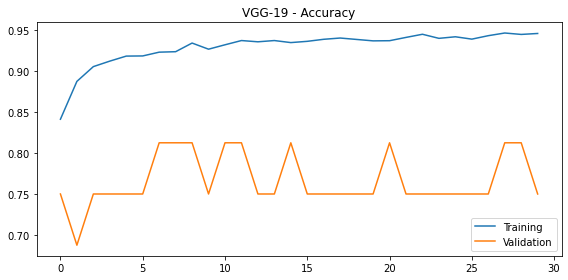

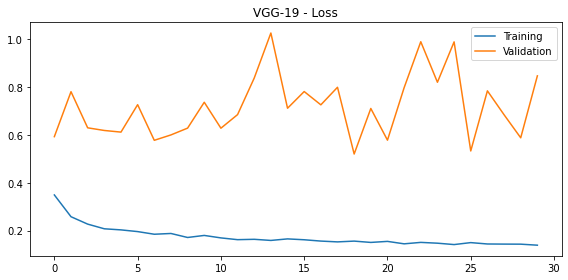

In [71]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('VGG-19 - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('VGG-19 - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

20/20 [==============================] - 49s 2s/step


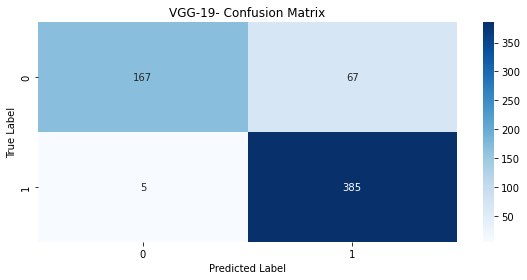

In [72]:
plot_confusion('VGG-19- Confusion Matrix', '8-vgg-conf')

This confision matrix shows us that

##### _______________________________________________

In [73]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 49s 2s/step - loss: 0.3522 - binary_accuracy: 0.8846 - precision: 0.8518 - recall: 0.9872


In [74]:
model_name = 'VGG-19'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.743590,1.526630,0.711397,0.992308
1,Increased Batch Size,0.802885,0.779359,0.768612,0.979487
2,Augmented Training Data,0.774038,1.199942,0.738050,0.989744
3,More Layers,0.758013,0.648688,0.723364,0.992308
4,RMSprop Optimizer,0.870192,0.302059,0.925620,0.861538
5,Adam Optimizer,0.822115,0.437568,0.785276,0.984615
6,Dropout Regularization,0.879808,0.319388,0.852349,0.976923
7,VGG-19,0.884615,0.352224,0.851770,0.987179


We can see from the dataframe storing the scores that 

###### _____________________________________________

In [75]:
#save info for later retrieval:

#model and history
model.save('./models/8-vgg-19')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/8-vgg-19-acc.png')
fig2.savefig('./img/8-vgg-19-loss.png')

INFO:tensorflow:Assets written to: ./models/8-vgg-19\assets


INFO:tensorflow:Assets written to: ./models/8-vgg-19\assets


### Model 9 - Fine Tuning VGG-19

# see ref!

In [ ]:
vgg.trainable = True
set_trainable = False
for layer in vgg.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
#compile
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

model.summary()

In [ ]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

#### Evaluating

Now that the model has finished fitting to the data (taking about _______________________________________ seconds), we can start by visualizing its accuracy and loss throughout each epoch:

##### ___________________________________________________

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Fine Tuned VGG-19 - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('Fine Tuned VGG-19 - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('Fine Tuned VGG-19- Confusion Matrix', '9-tuned-vgg-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'Fine Tuned VGG-19'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/8-tuned-vgg-19')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/9-tuned-vgg-19-acc.png')
fig2.savefig('./img/9-tuned-vgg-19-loss.png')

## Best Model - More Epochs

# TO DO- 

### make gpu work

# with tf.device('/GPU:0'):


SAVE SKELLY IMGS

early stopping ON EACH

MAKE GPU WORK 

visualize activations at end!


#plot model??

# utils.plot_model(model=nt_model,to_file='images/nt_model.png',show_shapes=True,dpi=64)

***
***
***
***

# Conclusions